In [ ]:

from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
import pandas as pd
import numpy as np
from time import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
tf.random.set_seed(42)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/data/cov_final.csv')

In [ ]:
df

,confirmed_cases,Enrolled in Educational Institution (%),HH with Disability (%),Total HH (House Hold),Literacy Rate,% of all employed persons ( age 15-24),No Education,LFP (Labour Force Participation) - unemployed,LFPR (Labour Force Participation Rate) (%) (age 5-14),Area,Population (2011),Density (/km2),doses,Ratio,RC,GISJOIN,Date
0,0,31.4,6.51,17722.0,58.98,27.2,1.1,41.7,4.5,3959.0,1476090.0,373.0,1329733.0,0.16,0.06,Bagerhat,11
1,0,31.4,6.51,17722.0,58.98,27.2,1.1,41.7,4.5,3959.0,1476090.0,373.0,1329733.0,0.17,0.03,Bagerhat,18
2,0,31.4,6.51,17722.0,58.98,27.2,1.1,41.7,4.5,3959.0,1476090.0,373.0,1329733.0,0.20,-0.08,Bagerhat,25
3,0,31.4,6.51,17722.0,58.98,27.2,1.1,41.7,4.5,3959.0,1476090.0,373.0,1329733.0,0.29,-0.32,Bagerhat,32
4,0,31.4,6.51,17722.0,58.98,27.2,1.1,41.7,4.5,3959.0,1476090.0,373.0,1329733.0,0.33,-0.40,Bagerhat,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6587,120,35.4,5.77,16041.0,48.71,25.5,0.4,34.8,3.6,1810.0,1390042.0,768.0,1126003.0,0.18,0.11,Thakurgaon,697
6588,293,35.4,5.77,16041.0,48.71,25.5,0.4,34.8,3.6,1810.0,1390042.0,768.0,1126003.0,0.23,0.01,Thakurgaon,704
6589,207,35.4,5.77,16041.0,48.71,25.5,0.4,34.8,3.6,1810.0,1390042.0,768.0,1126003.0,0.25,-0.04,Thakurgaon,711
6590,80,35.4,5.77,16041.0,48.71,25.5,0.4,34.8,3.6,1810.0,1390042.0,768.0,1126003.0,0.22,0.06,Thakurgaon,718


In [ ]:
df['GISJOIN'].unique()

array(['Bagerhat', 'Bandarban', 'Barguna', 'Barisal', 'Bhola', 'Bogra',
       'Brahmanbaria', 'Chandpur', 'Chittagong', 'Chuadanga',
       "Cox's Bazar", 'Cumilla', 'Dhaka', 'Dinajpur', 'Faridpur', 'Feni',
       'Gaibandha', 'Gazipur', 'Gopalganj', 'Hobiganj', 'Jamalpur',
       'Jessore', 'Jhalokathi', 'Jhinaidah', 'Joypurhat', 'Khagrachhari',
       'Khulna', 'Kishorganj', 'Kurigram', 'Kustia', 'Laksmipur',
       'Lalmonirhat', 'Madaripur', 'Magura', 'Manikganj', 'Meherpur',
       'Mouluvi Bazar', 'Munshiganj', 'Mymenshing', 'Narail',
       'Narayanganj', 'Narshindi', 'Natore', 'Netrokona', 'Nilphamari',
       'Naogaon', 'Noakhali', 'Nowabganj', 'Pabna', 'Panchagar',
       'Patuakhali', 'Perojpur', 'Rajbari', 'Rajshahi', 'Rangamati',
       'Rangpur', 'Sariatpur', 'Satkhira', 'Sherpur', 'Sirajganj',
       'Sunamganj', 'Sylhet', 'Tangail', 'Thakurgaon'], dtype=object)

In [ ]:
df=df.loc[df['GISJOIN']=='Dhaka']

In [ ]:
df.drop('Date', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df=df[['GISJOIN','confirmed_cases','Ratio','RC']]

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
n_days = 1
n_features = 3

prediction_dict = {}

state='Dhaka'
#for state in states:
print('-----', state, '-----')

state_df = df[df['GISJOIN']=='Dhaka']
values = state_df[['confirmed_cases','Ratio','RC']].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

score_dict = {'train_rmse':[],
              'test_rmse': [],
             'test_pred': [],
              'ground_truth': []}
             

for i in range(0,1):
    # split into train and test sets
    values = reframed.values
    n_train_days = int(len(values) * 0.8)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    # split into input and outputs
    n_obs = n_days * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    # print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
    # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


    # design network
    model = Sequential()
    model.add(LSTM(64, activation='relu',
                   return_sequences=True,
                   input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')


    # fit network
    history = model.fit(train_X, train_y, epochs=200, 
                        batch_size=72, 
                        validation_data=(test_X, test_y), 
                        verbose=2, shuffle=False)
    # plot history
    #     pyplot.plot(history.history['loss'], label='train')
    #     pyplot.plot(history.history['val_loss'], label='test')
    #     pyplot.legend()
    #     pyplot.show()

    model_predict_train = model.predict(train_X)
    train_X = train_X.reshape((train_X.shape[0], n_days*n_features))
    # invert scaling for forecast
    inv_yhat_train = concatenate((model_predict_train, train_X[:, -(n_features-1):]), axis=1)
    inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
    inv_yhat_train = inv_yhat_train[:,0]
    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    inv_y_train = concatenate((train_y, train_X[:, -(n_features-1):]), axis=1)
    inv_y_train = scaler.inverse_transform(inv_y_train)
    inv_y_train = inv_y_train[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
    print('Train RMSE: %.3f' % rmse)
    score_dict['train_rmse'].append(rmse)

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    score_dict['test_rmse'].append(rmse)
    score_dict['test_pred'].append(inv_yhat)
    score_dict['ground_truth'].append(inv_y)
    model_predict = concatenate([inv_yhat_train, inv_yhat])
    prediction_dict[state] = model_predict
    
print(DataFrame(score_dict))

----- Dhaka -----
   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.001360   0.000000   0.843373  0.000000
2   0.000000   0.051282   0.807229  0.000076
3   0.000076   0.179487   0.614458  0.000076
4   0.000076   0.666667   0.228916  0.000630
5   0.000630   0.871795   0.048193  0.006474
Epoch 1/200
2/2 - 6s - loss: 0.2800 - val_loss: 0.0862 - 6s/epoch - 3s/step
Epoch 2/200
2/2 - 0s - loss: 0.2740 - val_loss: 0.0798 - 51ms/epoch - 26ms/step
Epoch 3/200
2/2 - 0s - loss: 0.2681 - val_loss: 0.0730 - 46ms/epoch - 23ms/step
Epoch 4/200
2/2 - 0s - loss: 0.2620 - val_loss: 0.0661 - 41ms/epoch - 21ms/step
Epoch 5/200
2/2 - 0s - loss: 0.2559 - val_loss: 0.0615 - 50ms/epoch - 25ms/step
Epoch 6/200
2/2 - 0s - loss: 0.2496 - val_loss: 0.0572 - 45ms/epoch - 23ms/step
Epoch 7/200
2/2 - 0s - loss: 0.2431 - val_loss: 0.0528 - 61ms/epoch - 31ms/step
Epoch 8/200
2/2 - 0s - loss: 0.2364 - val_loss: 0.0495 - 51ms/epoch - 25ms/step
Epoch 9/200
2/2 - 0s - loss: 0.2292 - val_loss: 0.0492 - 49ms/epoch - 24ms/s

In [ ]:
score_dict_df = DataFrame(score_dict)


In [ ]:
score_dict_df 


,train_rmse,test_rmse,test_pred,ground_truth
0,281.539643,407.553026,"[3041.768, 2932.4033, 2085.046, 2915.3203, 377...","[3053.6921, 3053.6921, 2035.7948, 3053.6921, 4..."


In [ ]:
df['Date'] = pd.date_range(start='2020-03-08', end='2022-02-20', periods=103)

In [ ]:
inv_y

array([ 3053.6921,  3053.6921,  2035.7948,  3053.6921,  4071.5896,
        2035.7948,  2035.7948,  3053.6921,  4071.5896,  2035.7948,
        7125.284 ,  2035.7948,  1017.8974,  1017.8974,  1017.8974,
        1017.8974,  2035.7948,  4071.5896,  9161.076 , 10178.977 ,
        8143.179 ], dtype=float32)

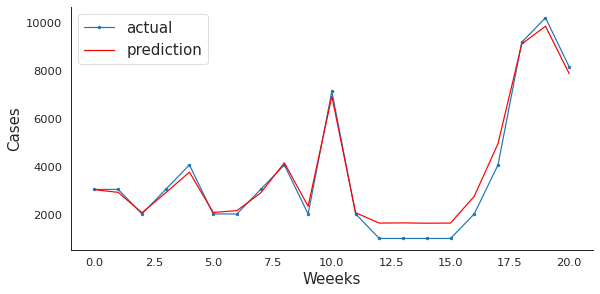

In [ ]:
aa=[x for x in range(21)]
plt.figure(figsize=(8,4))
plt.plot(aa, inv_y, marker='.', label="actual")
plt.plot(aa, inv_yhat, 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Cases', size=15)
plt.xlabel('Weeeks', size=15)
plt.legend(fontsize=15)
plt.show();

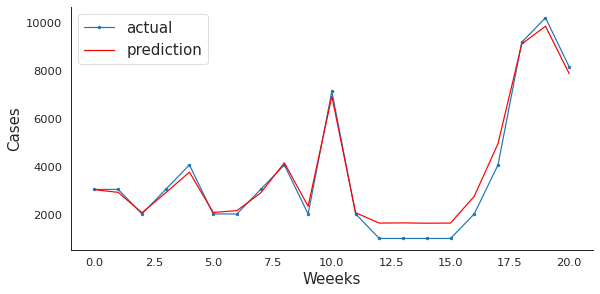

In [ ]:
aa=[x for x in range(21)]
plt.figure(figsize=(8,4))
plt.plot(aa, inv_y, marker='.', label="actual")
plt.plot(aa, inv_yhat, 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Cases', size=15)
plt.xlabel('Weeeks', size=15)
plt.legend(fontsize=15)
plt.show();